In [209]:
# 最新のCOVID-19のデータをWikiから（厚労省のデータ一覧）取得
from urllib import request
from bs4 import BeautifulSoup
url = 'https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Japan'
response = request.urlopen(url)
soup = BeautifulSoup(response)
response.close()

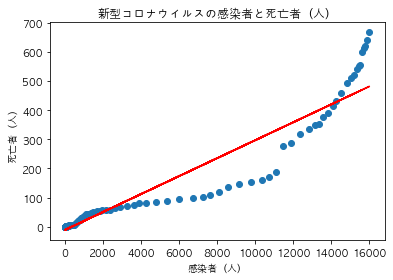

RMSE Test :63.21741122235123
R^2 Train : 0.920, Test : 0.882


In [250]:
# WikipediaデータからCOVID-19のデータを取得
import re
import pandas as pd
def wikipedia2covid19():
    extract_int = lambda string: re.search(r'[\d,]+', string)
    trs = soup.find('div', class_='barbox tright').select('table')[0].select('tbody')[0].select('tr')
    data = []
    for rows in trs:
        row = rows.select('td.bb-04em')
        if len(row) == 0:
            continue
        date = row[0].text
        case = extract_int(row[1].text)
        if case != None:
            case = case.group()
        death = extract_int(row[2].text)
        if death != None:
            death = death.group()
        data.append({'date': date, 'case': case, 'death': death})
    return pd.DataFrame(data)

# データを整形する
import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
def plot_scatter_covid19(df, y_test_pred):
    auto_reshape_int = lambda column: pd.DataFrame([0 if x == None else int(x.replace(',', '')) for x in column.values]).values.reshape(-1, 1)
    case = auto_reshape_int(df.case)
    death = auto_reshape_int(df.death)
    X_train, X_test, y_train, y_test = train_test_split(case, death, test_size=0.3, random_state=0)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    plt.scatter(case, death)
    plt.plot(X_test, y_test_pred, color='red')
    plt.title('新型コロナウイルスの感染者と死亡者（人）')
    plt.xlabel('感染者（人）')
    plt.ylabel('死亡者（人）')
    plt.show()

from math import sqrt
from sklearn.metrics import mean_squared_error
def score_rmse_r2(y_test_pred):
    return ({'rmse': sqrt(mean_squared_error(y_test, y_test_pred)), 'train': lr.score(X_train, y_train), 'test': lr.score(X_test, y_test) })


y_test_pred = lr.predict(X_test)
plot_scatter_covid19(pd.DataFrame(wikipedia2covid19()), y_test_pred)
score = score_rmse_r2(y_test_pred)

print('RMSE Test :' + str(score['rmse']))
print('R^2 Train : %.3f, Test : %.3f' % (score['train'], score['test']))